In [7]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, datasets, utils, losses, regularizers
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator



## Section 1: Data Loading and Pre-processing

In [8]:

# Define transformations for training and testing data
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=transform)

# Split into training set and validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Creating a DataLoader
trainloader = DataLoader(train_subset, batch_size=128, shuffle=True)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Convert data to NumPy format
def pytorch_to_numpy(dataloader):
    images_list = []
    labels_list = []
    for images, labels in dataloader:
        images_np = images.numpy().transpose((0, 2, 3, 1))  
        labels_np = labels.numpy()
        images_list.append(images_np)
        labels_list.append(labels_np)
    return np.concatenate(images_list), np.concatenate(labels_list)

# Convert training, validation, and test data to NumPy format
x_train, y_train = pytorch_to_numpy(trainloader)
x_val, y_val = pytorch_to_numpy(valloader)
x_test, y_test = pytorch_to_numpy(testloader)


# Keep the label as integer type
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)



In [10]:
# Display dataset information
print(f"Training set: {x_train.shape[0]} images")
print(f"Validation set: {x_val.shape[0]} images")
print(f"Test set: {x_test.shape[0]} images")
print(f"Image size: {x_train.shape[1:]} (height x width x channels)")
print(f"Number of classes: {len(np.unique(np.array(y_train)))}")


Training set: 40000 images
Validation set: 10000 images
Test set: 10000 images
Image size: (32, 32, 3) (height x width x channels)
Number of classes: 10


# Section 2: Baseline Models

## CNN Bseline Model

In [ ]:

# Building a simple CNN model
def create_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the model
cnn_model = create_cnn(input_shape=(32, 32, 3), num_classes=10)
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

# Training the model
history = cnn_model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.1)

# Print final test accuracy
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)
print(f"CNN Model Test Accuracy: {cnn_test_acc:.2%}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3177 - loss: 1.8413 - val_accuracy: 0.4882 - val_loss: 1.3998
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5214 - loss: 1.3226 - val_accuracy: 0.5388 - val_loss: 1.2626
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5848 - loss: 1.1759 - val_accuracy: 0.5852 - val_loss: 1.1653
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6251 - loss: 1.0597 - val_accuracy: 0.5990 - val_loss: 1.1371
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6507 - loss: 0.9853 - val_accuracy: 0.6064 - val_loss: 1.1169
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6799 - loss: 0.9158 - val_accuracy: 0.6284 - val_loss: 1.0672
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6984 - loss: 0.8639 - val_accuracy: 0.6322 - val_loss: 1.0562
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - loss: 0.8043 - val_accuracy: 0

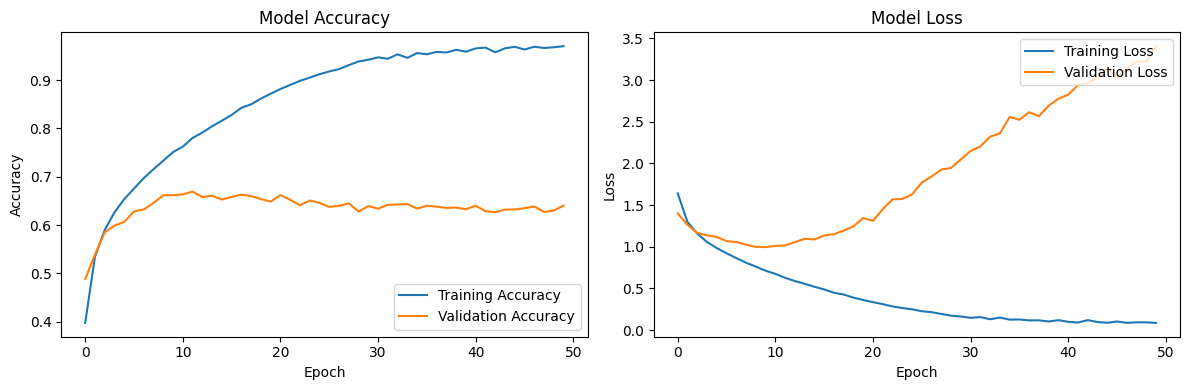

In [ ]:
# Plotting accuracy and loss visualization

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## AlexNet Baseline Model

In [ ]:
# Defining the AlexNet model
def create_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), strides=1, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2), strides=2),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the AlexNet model
alexnet_model = create_alexnet()

# Compile the model
alexnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Training the model
history = alexnet_model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_split=0.1
)

# Evaluate the model on the test set and print result
alexnet_test_loss, alexnet_test_acc = alexnet_model.evaluate(x_test, y_test, verbose=2)
print(f"AlexNet Model Test Accuracy: {alexnet_test_acc:.2%}")



Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.2788 - loss: 1.9144 - val_accuracy: 0.5218 - val_loss: 1.3129
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5432 - loss: 1.2680 - val_accuracy: 0.6324 - val_loss: 1.0540
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6585 - loss: 0.9845 - val_accuracy: 0.6790 - val_loss: 0.9223
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7208 - loss: 0.7916 - val_accuracy: 0.6998 - val_loss: 0.8779
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7718 - loss: 0.6605 - val_accuracy: 0.7268 - val_loss: 0.7971
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8093 - loss: 0.5481 - val_accuracy: 0.7202 - val_loss: 0.8414
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8384 - loss: 0.4605 - val_accuracy: 0.7264 - val_loss: 0.8664
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8734 - loss: 0.3697 - val_accuracy: 

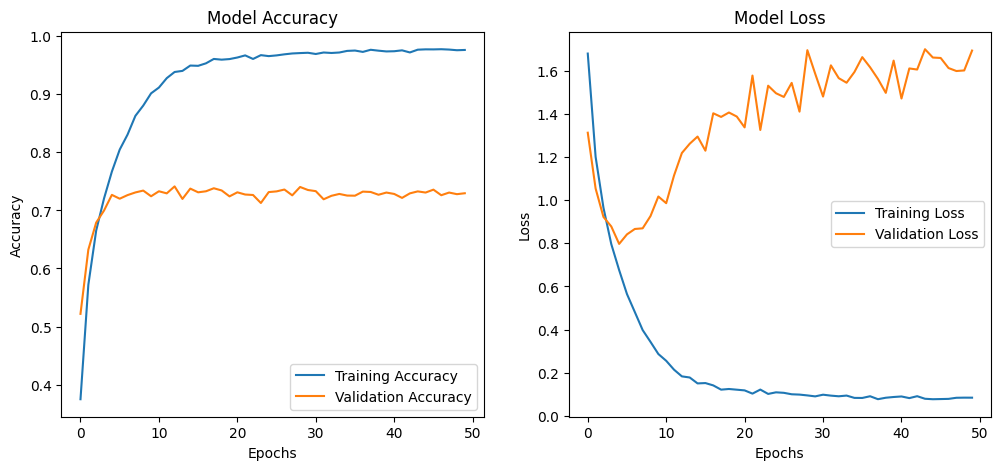

In [ ]:
# Plotting accuracy and loss visualization

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## ResNet18 Baseline Model

In [ ]:


# Define a simplie ResNet basic block
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False):
        super(ResidualBlock, self).__init__()
        strides = 2 if downsample else 1
        self.conv1 = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, (3, 3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        if downsample:
            self.shortcut = models.Sequential([
                layers.Conv2D(filters, (1, 1), strides=2, padding='same'),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += self.shortcut(inputs)
        return tf.nn.relu(x)

# Create basic ResNet-18 model
class create_ResNet18(tf.keras.Model):
    def __init__(self):
        super(create_ResNet18, self).__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.layer1 = self._build_residual_layer(64, 2)
        self.layer2 = self._build_residual_layer(128, 2, downsample=True)
        self.layer3 = self._build_residual_layer(256, 2, downsample=True)
        self.layer4 = self._build_residual_layer(512, 2, downsample=True)
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(10, activation='softmax')

    def _build_residual_layer(self, filters, blocks, downsample=False):
        layers_list = []
        for i in range(blocks):
            if i == 0 and downsample:
                layers_list.append(ResidualBlock(filters, downsample=True))
            else:
                layers_list.append(ResidualBlock(filters))
        return models.Sequential(layers_list)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.global_avg_pool(x)
        return self.fc(x)

# Create and compile model
model = create_ResNet18()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Training model
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the model on the test set and print result
resnet18_test_loss, resnet18_test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"ResNet18 Test Accuracy: {resnet18_test_acc:.2%}")




Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.3836 - loss: 1.7994 - val_accuracy: 0.4654 - val_loss: 1.9151
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6451 - loss: 0.9984 - val_accuracy: 0.6049 - val_loss: 1.3212
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7518 - loss: 0.7127 - val_accuracy: 0.7057 - val_loss: 0.8608
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8098 - loss: 0.5478 - val_accuracy: 0.7579 - val_loss: 0.7219
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8493 - loss: 0.4329 - val_accuracy: 0.7827 - val_loss: 0.6611
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8807 - loss: 0.3442 - val_accuracy: 0.7883 - val_loss: 0.6801
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9062 - loss: 0.2638 - val_accuracy: 0.7904 - val_loss: 0.6825
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9357 - loss: 0.1853 - val_acc

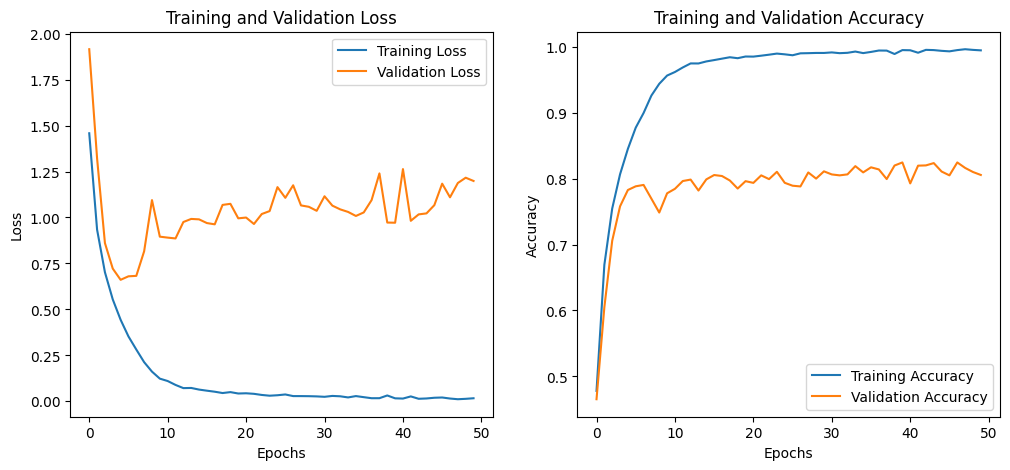

In [ ]:
# Plotting accuracy and loss visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Section 3: Models Improvement




## Improved CNN Model

In [78]:

# Define an improved CNN model
def create_improved_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),  
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Create Model
improved_cnn_model = create_improved_cnn(input_shape=(32, 32, 3), num_classes=10)

# Compile model
improved_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Setting data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Training the model
history = improved_cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model on the test set and print result
improved_cnn_test_loss, improved_cnn_test_acc = improved_cnn_model.evaluate(x_test, y_test, verbose=2)
print(f"Improved CNN Model Test Accuracy: {improved_cnn_test_acc:.2%}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 - 33s - 43ms/step - accuracy: 0.3665 - loss: 1.7156 - val_accuracy: 0.5061 - val_loss: 1.3659
Epoch 2/50
782/782 - 29s - 37ms/step - accuracy: 0.5043 - loss: 1.3724 - val_accuracy: 0.5508 - val_loss: 1.2873
Epoch 3/50
782/782 - 29s - 37ms/step - accuracy: 0.5649 - loss: 1.2260 - val_accuracy: 0.5980 - val_loss: 1.1507
Epoch 4/50
782/782 - 29s - 37ms/step - accuracy: 0.5976 - loss: 1.1385 - val_accuracy: 0.6246 - val_loss: 1.0827
Epoch 5/50
782/782 - 29s - 37ms/step - accuracy: 0.6275 - loss: 1.0625 - val_accuracy: 0.6420 - val_loss: 1.0359
Epoch 6/50
782/782 - 29s - 37ms/step - accuracy: 0.6478 - loss: 1.0070 - val_accuracy: 0.6570 - val_loss: 0.9891
Epoch 7/50
782/782 - 29s - 37ms/step - accuracy: 0.6644 - loss: 0.9651 - val_accuracy: 0.6916 - val_loss: 0.8907
Epoch 8/50
782/782 - 29s - 37ms/step - accuracy: 0.6776 - loss: 0.9312 - val_accuracy: 0.7069 - val_loss: 0.8579
Epoch 9/50
782/782 - 29s - 37ms/step - accuracy: 0.6851 - loss: 0.9037 - val_accuracy: 0.7018 - val_loss: 0

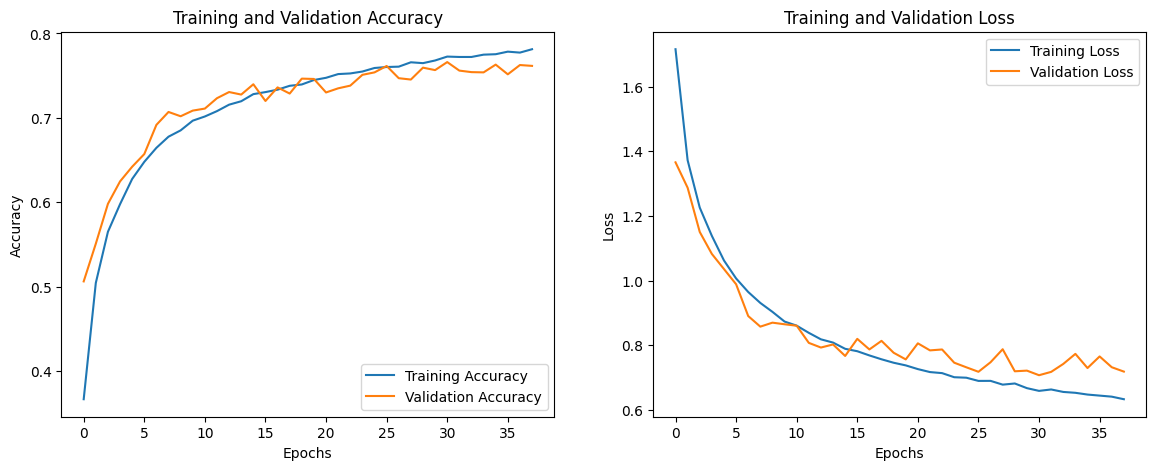

In [79]:
# Plotting accuracy and loss visualization
def plot_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

## Improved AlexNet Model

In [89]:
# Define the improved AlexNet model
def create_improved_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), strides=1, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build the model
improved_alexnet_model = create_improved_alexnet()

# Compile the model
improved_alexnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Setting data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2
)
datagen.fit(x_train)

# Setting early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training the model
history = improved_alexnet_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

# Evaluate the model on the test set and print result
improved_alexnet_test_loss, improved_alexnet_test_acc = improved_alexnet_model.evaluate(x_test, y_test, verbose=2)
print(f"Improved AlexNet Model Test Accuracy: {improved_alexnet_test_acc:.2%}")


Epoch 1/50
782/782 - 41s - 52ms/step - accuracy: 0.2583 - loss: 2.0369 - val_accuracy: 0.4038 - val_loss: 1.6187 - learning_rate: 5.0000e-04
Epoch 2/50
782/782 - 31s - 39ms/step - accuracy: 0.3754 - loss: 1.7219 - val_accuracy: 0.4804 - val_loss: 1.4653 - learning_rate: 5.0000e-04
Epoch 3/50
782/782 - 31s - 39ms/step - accuracy: 0.4506 - loss: 1.5345 - val_accuracy: 0.5384 - val_loss: 1.2556 - learning_rate: 5.0000e-04
Epoch 4/50
782/782 - 31s - 39ms/step - accuracy: 0.5054 - loss: 1.4140 - val_accuracy: 0.5538 - val_loss: 1.2493 - learning_rate: 5.0000e-04
Epoch 5/50
782/782 - 31s - 39ms/step - accuracy: 0.5441 - loss: 1.3184 - val_accuracy: 0.6174 - val_loss: 1.0864 - learning_rate: 5.0000e-04
Epoch 6/50
782/782 - 31s - 40ms/step - accuracy: 0.5692 - loss: 1.2476 - val_accuracy: 0.6641 - val_loss: 0.9743 - learning_rate: 5.0000e-04
Epoch 7/50
782/782 - 31s - 40ms/step - accuracy: 0.5931 - loss: 1.1871 - val_accuracy: 0.6732 - val_loss: 0.9408 - learning_rate: 5.0000e-04
Epoch 8/50
78

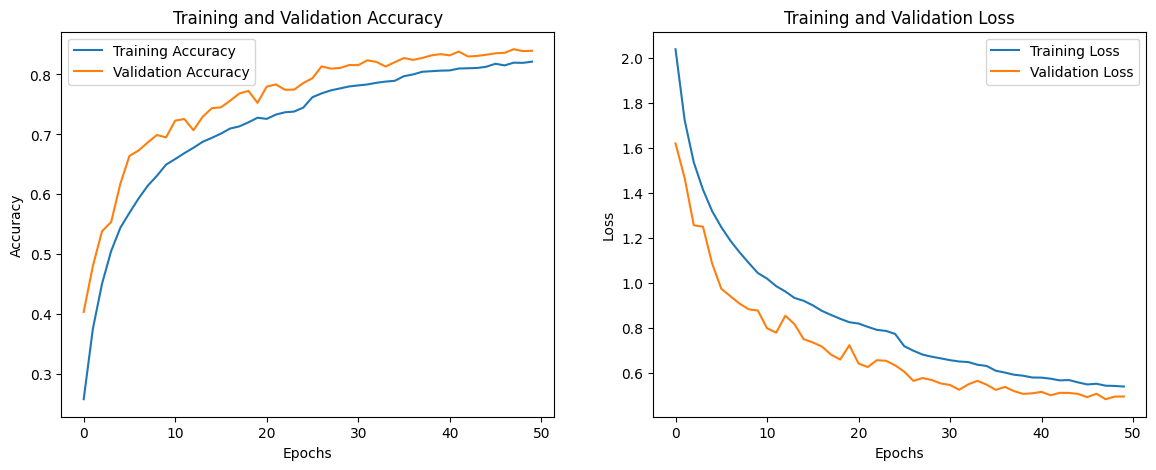

In [90]:
# Plotting accuracy and loss visualization
def plot_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

## Improved ResNet18 Model

In [91]:

# Define a ResNet basic block with residual connections and Dropout
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        strides = 2 if downsample else 1
        self.conv1 = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)
        self.conv2 = layers.Conv2D(filters, (3, 3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)

        if downsample:
            self.shortcut = models.Sequential([
                layers.Conv2D(filters, (1, 1), strides=2, padding='same'),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        x += self.shortcut(inputs)
        return tf.nn.relu(x)

# Define an improved ResNet18 model
class ImprovedResNet18_Model(tf.keras.Model):
    def __init__(self):
        super(ImprovedResNet18_Model, self).__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.layer1 = self._build_residual_layer(64, 2)
        self.layer2 = self._build_residual_layer(128, 2, downsample=True)
        self.layer3 = self._build_residual_layer(256, 2, downsample=True)
        self.layer4 = self._build_residual_layer(512, 2, downsample=True)
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(10, activation='softmax')

    def _build_residual_layer(self, filters, blocks, downsample=False):
        layers_list = []
        for i in range(blocks):
            if i == 0 and downsample:
                layers_list.append(ResidualBlock(filters, downsample=True))
            else:
                layers_list.append(ResidualBlock(filters))
        return models.Sequential(layers_list)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.global_avg_pool(x)
        return self.fc(x)

# Creating and compiling the model
improved_ResNet18_model = ImprovedResNet18_Model()
improved_ResNet18_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# Defining Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = improved_ResNet18_model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data = (x_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set and print result
improved_resnet18_test_loss, improved_resnet18_test_loss = improved_ResNet18_model.evaluate(x_test, y_test, verbose=2)
print(f"Improved ResNet18 Model Test Accuracy: {improved_resnet18_test_loss:.2%}")


Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - accuracy: 0.2384 - loss: 2.1144 - val_accuracy: 0.3668 - val_loss: 2.1811
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4447 - loss: 1.5074 - val_accuracy: 0.4998 - val_loss: 1.4802
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5408 - loss: 1.2604 - val_accuracy: 0.5450 - val_loss: 1.4300
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5980 - loss: 1.1211 - val_accuracy: 0.5820 - val_loss: 1.2246
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6467 - loss: 0.9833 - val_accuracy: 0.6032 - val_loss: 1.2421
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6789 - loss: 0.9068 - val_accuracy: 0.6908 - val_loss: 0.9009
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7053 - loss: 0.8268 - val_accuracy: 0.6604 - val_loss: 1.1033
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7241 - loss: 0.7732 - val_acc

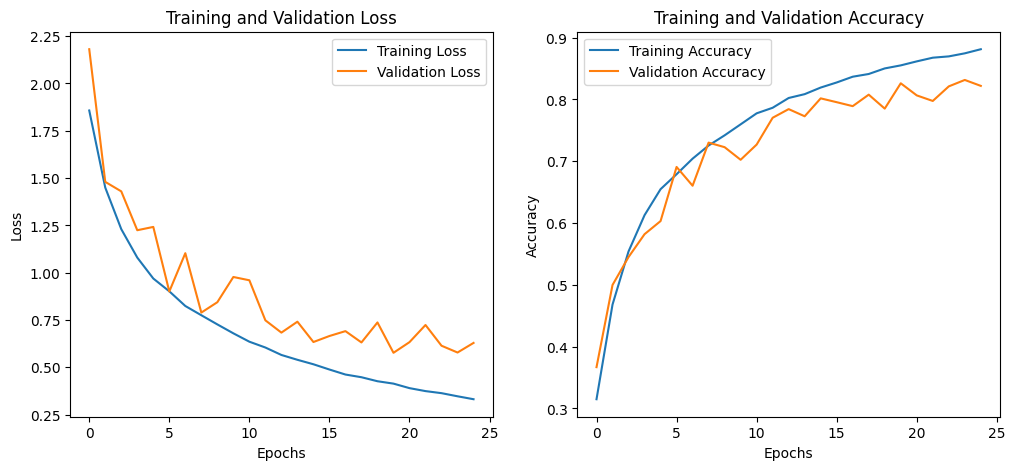

In [92]:
# Plotting accuracy and loss visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()